## case detection model

In [2]:
from functools import reduce

from typing import List

from multiprocessing import Pool

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from covid_model_deaths.globals import COLUMNS
from covid_model_deaths.data import drop_lagged_reports_by_location, add_moving_average_rates

from db_queries import get_location_metadata

import statsmodels.api as sm

pd.options.display.max_rows = 200

CASE_VERSION = '2020_05_09.01'
INF_VERSION = '2020_05_10.01'
TEST_VERSION = '2020_05_10.01'


## methods

In [126]:
def get_us_locations(location_set_version_id: int = 664) -> pd.DataFrame:
    df = get_location_metadata(location_set_id=111, location_set_version_id=location_set_version_id)
    df = df.loc[df['path_to_top_parent'].str.startswith('102,')]
    df = df.loc[df['most_detailed'] == 1]
    df = df[['location_id', 'location_name']].reset_index(drop=True)
    
    return df


def load_infection_file(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    
    return df[['loc_id', 'date', 'cases_draw']]


def compile_infections(loc_df: pd.DataFrame, n_draws: int = 1000):
    inf_dir = f'/ihme/covid-19/seir-inputs/{INF_VERSION}'
    
    # define location directories
    loc_dirs = [f'{inf_dir}/{location_name}_{location_id}' for location_id, location_name in zip(loc_df['location_id'], loc_df['location_name'])]
    data_files = [f'draw{n:04d}_prepped_deaths_and_cases_all_age.csv' for n in range(n_draws)]
    
    dfs =[]
    for loc_dir in loc_dirs:
        pool = Pool(20)
        df = pd.concat(pool.map(load_infection_file, [f'{loc_dir}/{data_file}' for data_file in data_files]))
        pool.close()
        pool.join()
        df = df.rename(index=str, columns={'loc_id':COLUMNS.location_id, 'cases_draw':'infections'})
        df[COLUMNS.date] = pd.to_datetime(df['date'])
        df = df.groupby([COLUMNS.location_id, COLUMNS.date], as_index=False)['infections'].mean()
        dfs.append(df)
    df = pd.concat(dfs)
    
    return df
    
    
def get_daily(df: pd.DataFrame, cum_var: str) -> pd.DataFrame:
    """Convert cumulative to daily."""
    assert len(df) == df[COLUMNS.date].unique().size
    data = df[cum_var].values
    data[1:] = df[cum_var].values[1:] - df[cum_var].values[:-1]
    
    return data

    
def smoother(df: pd.DataFrame, count_col: str) -> pd.DataFrame:
    """Apply smoothing pipeline to data."""
    # dataframe
    df = df.copy().sort_values(['location_id', 'Date']).reset_index(drop=True)

    # # drop last day if 0?
    # df = drop_lagged_reports_by_location(df, count_col)

    # remove day of week effect
    df = (
        df.groupby(COLUMNS.location_id)
          .apply(lambda x: remove_day_of_week_effect(x))
    ).reset_index()
    
    # smooth
    df = add_moving_average_rates(df, 'smoothed ln(rate)', -np.inf)
    
    return df[['location_id', 'Date', count_col, 'smoothed ln(rate)']]


def remove_day_of_week_effect(df: pd.DataFrame) -> pd.DataFrame:
    """
    Estimate and remove day-of-week effect (by location).
    
    Use weekly deaths as exposure?
    """
    pass


def test_for_synchrony(inf_df: pd.DataFrame, case_df: pd.DataFrame) -> float:
    """Find day adjustment that best aligns infections and reported cases."""
    pass


523


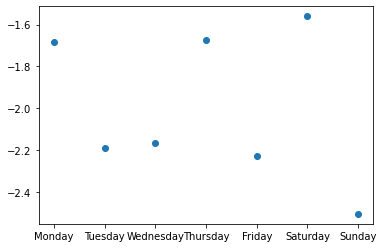

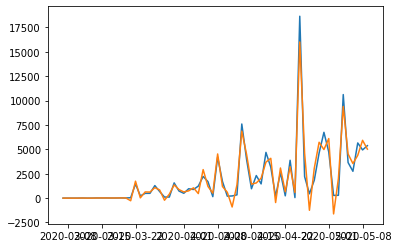

524


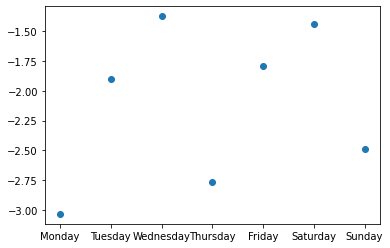

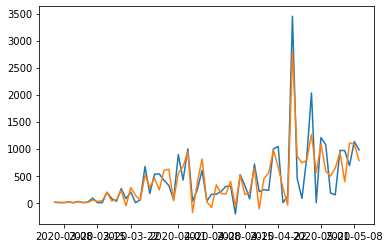

525


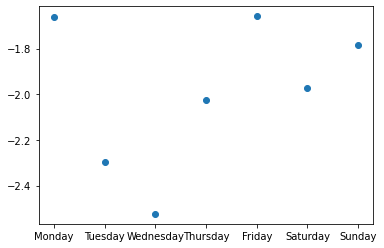

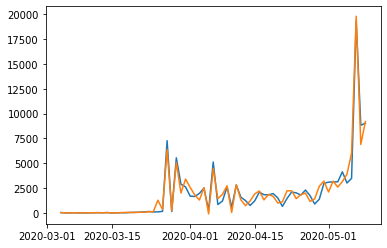

526


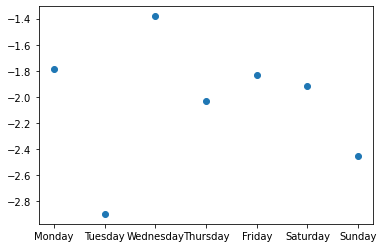

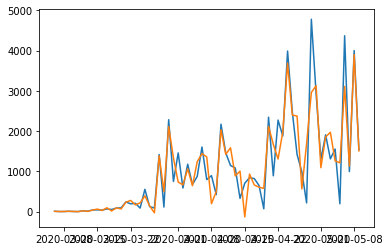

527


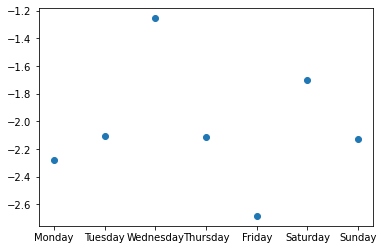

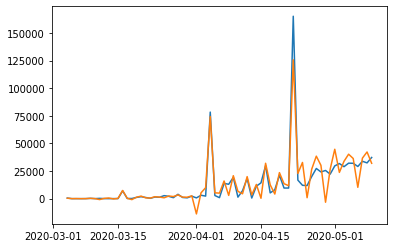

528


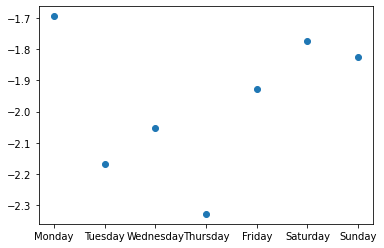

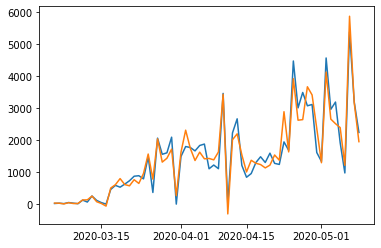

529


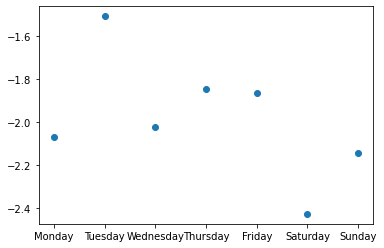

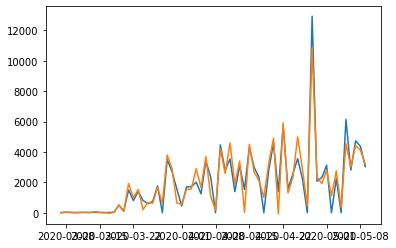

530


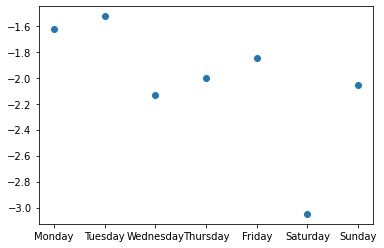

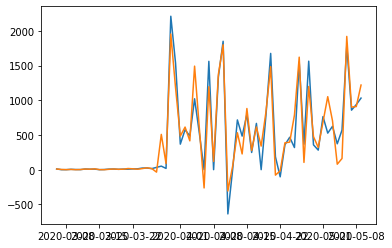

531


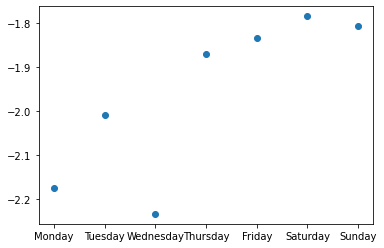

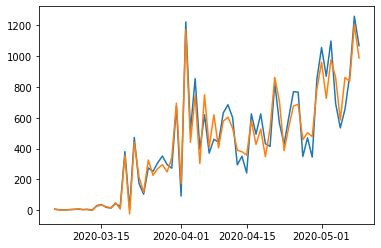

532


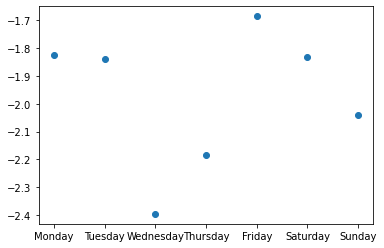

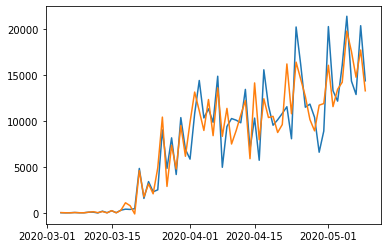

533


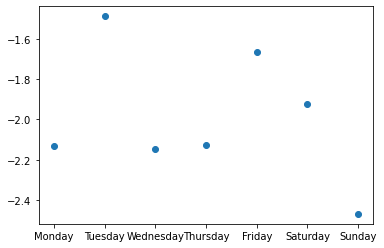

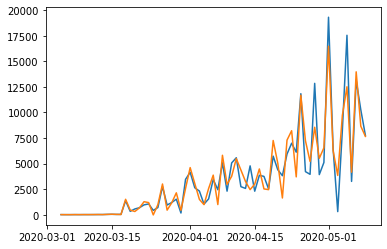

534


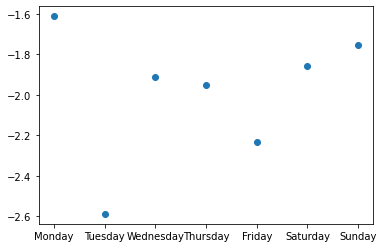

/ihme/covid-19/miniconda/envs/covid-deaths-2020-05-10_12-08-48/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


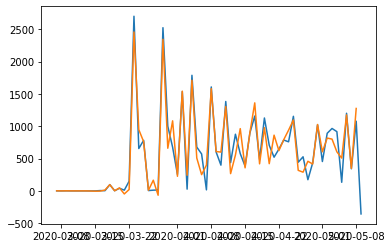

535


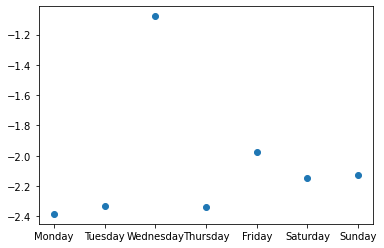

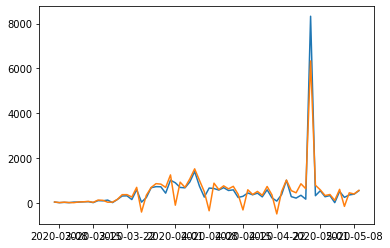

536


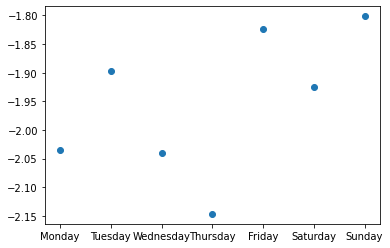

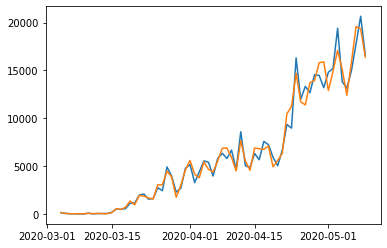

537


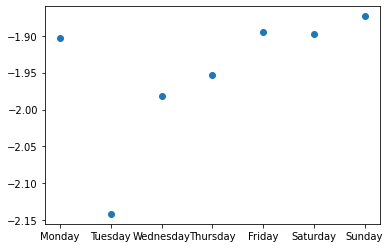

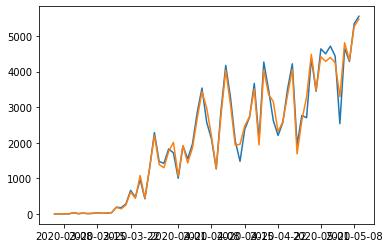

538


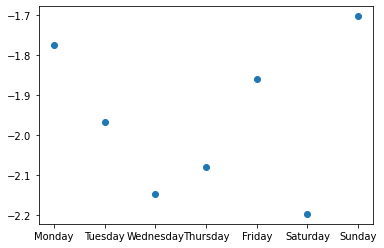

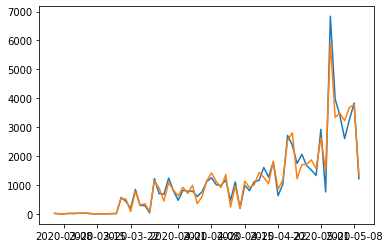

539


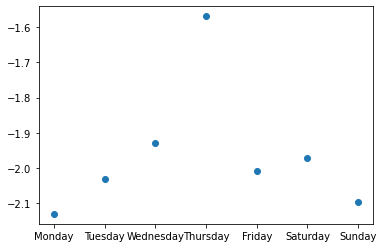

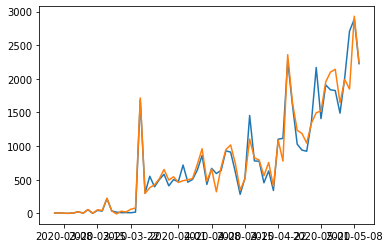

540


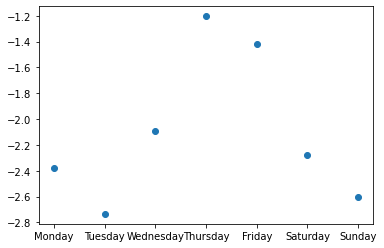

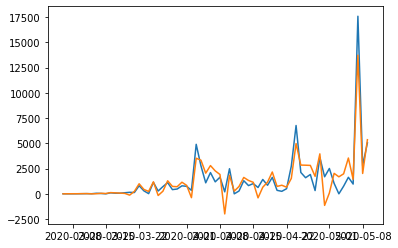

541


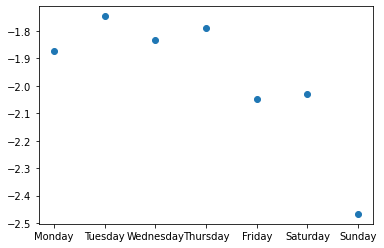

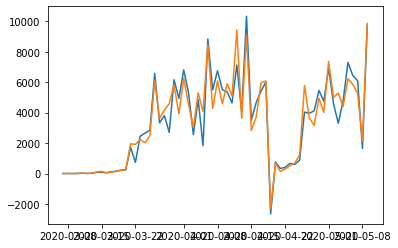

542


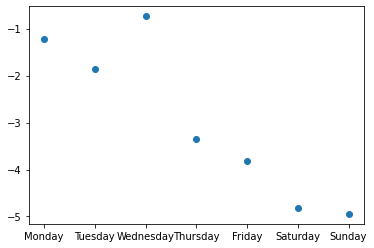

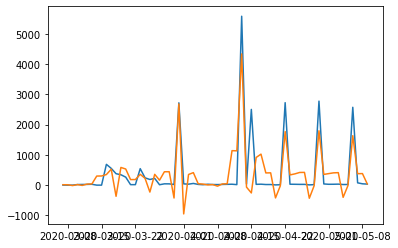

543


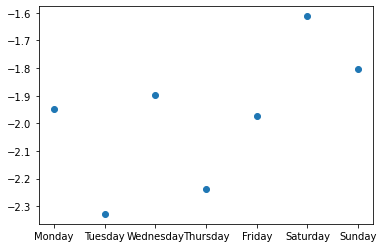

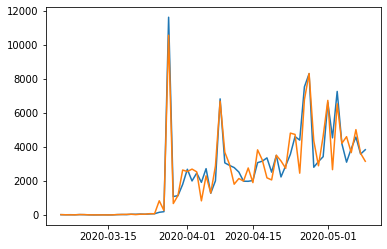

544


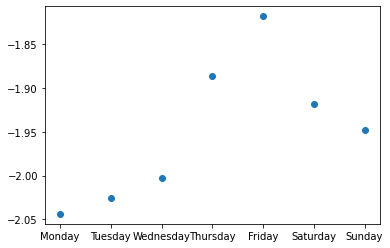

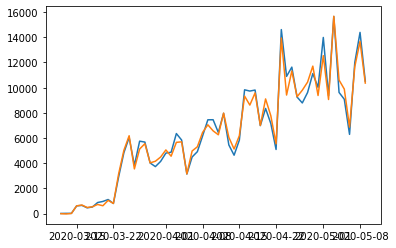

545


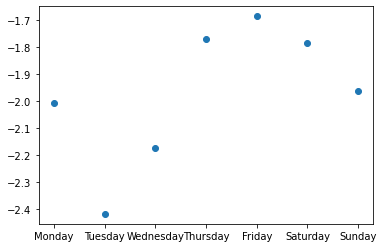

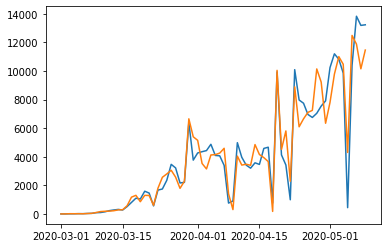

546


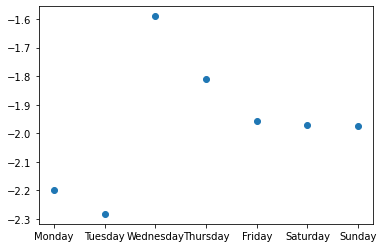

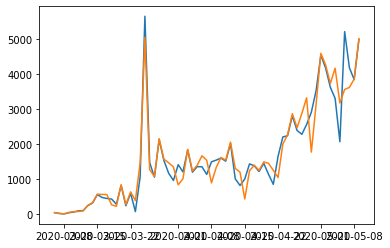

547


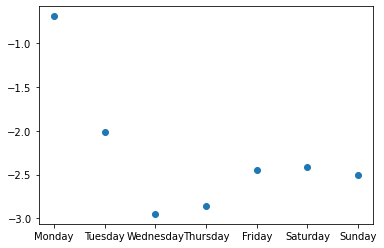

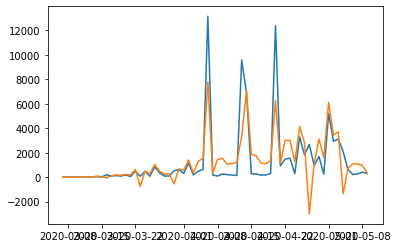

548


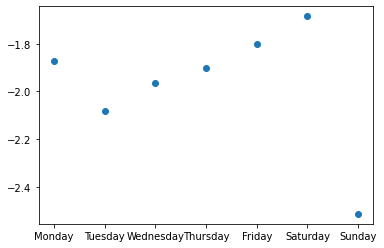

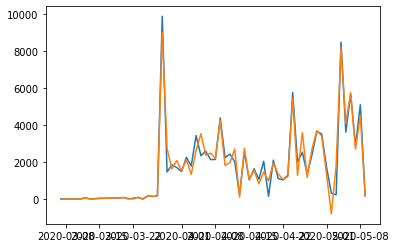

549


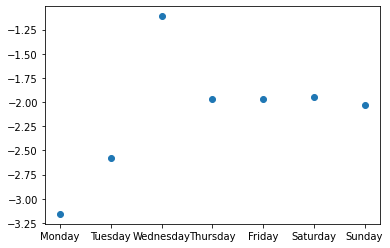

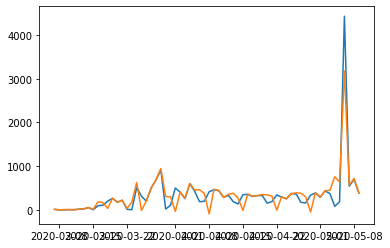

550


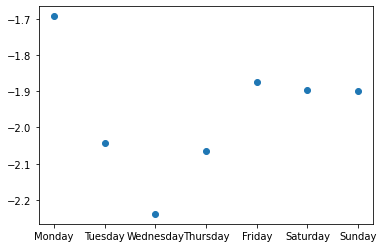

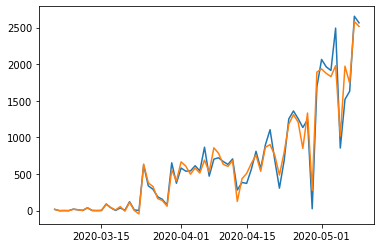

551


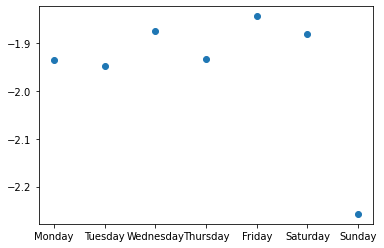

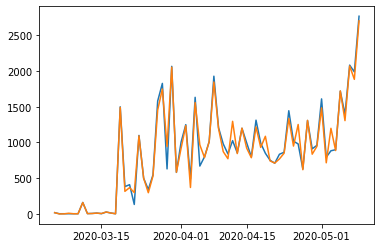

552


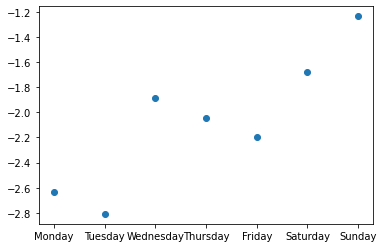

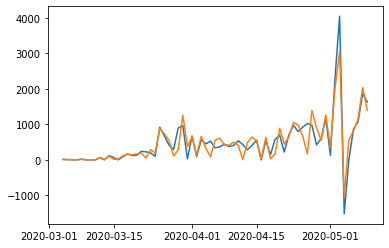

553


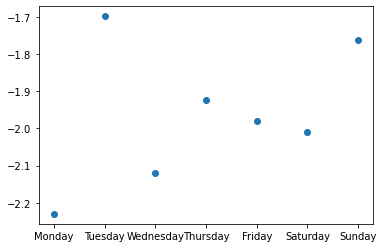

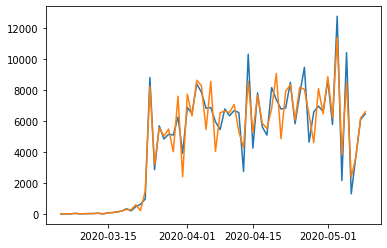

554


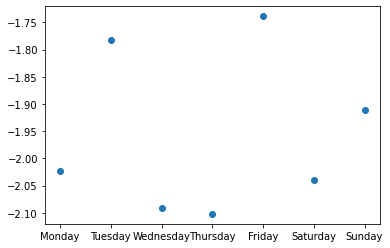

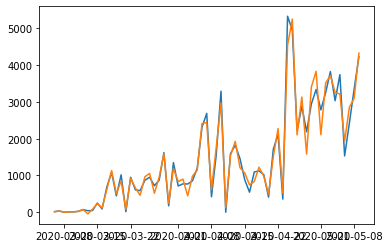

555


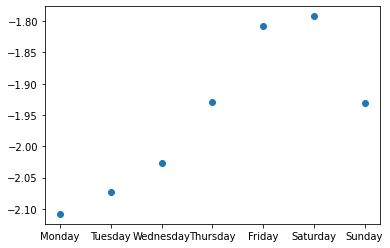

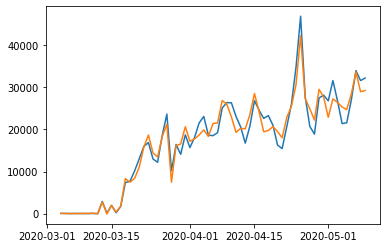

556


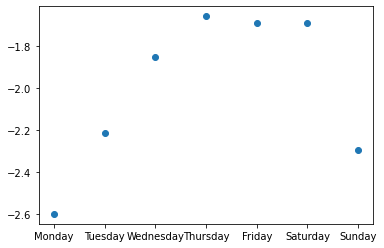

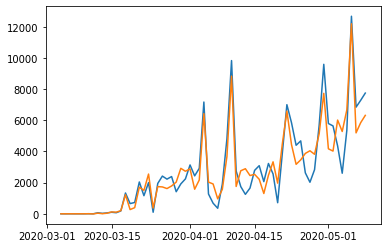

557


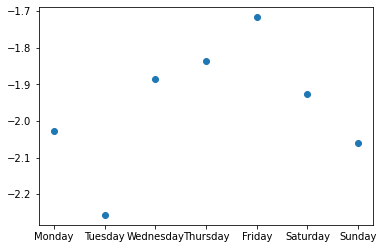

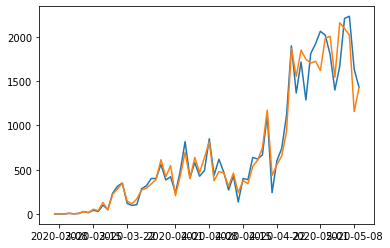

558


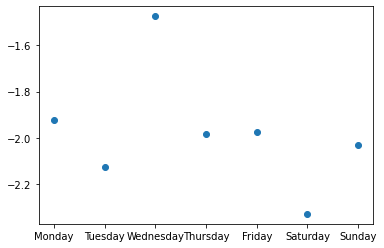

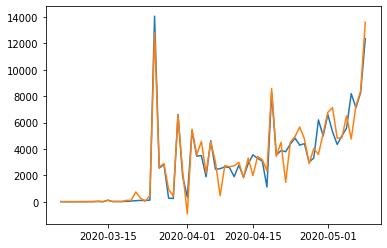

559


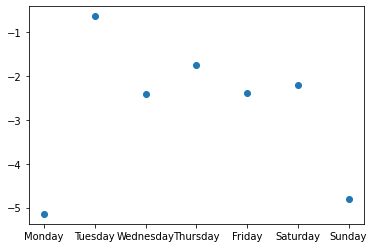

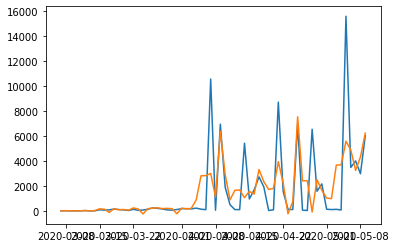

560


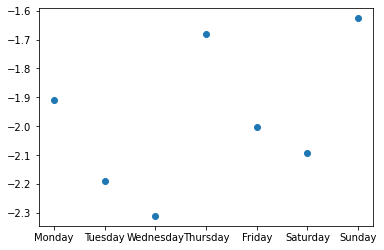

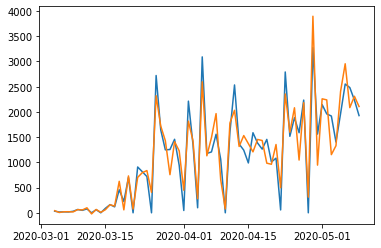

561


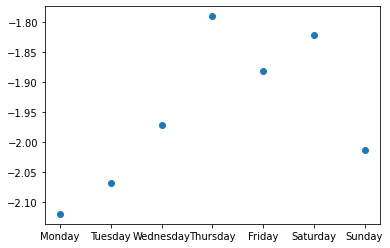

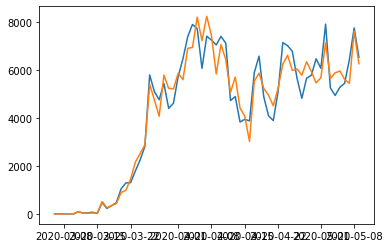

562


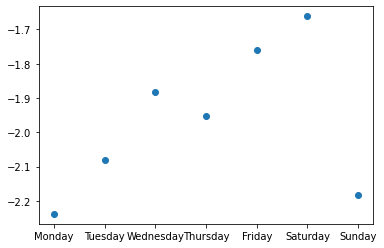

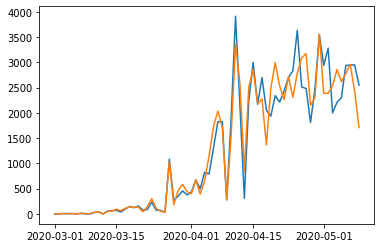

563


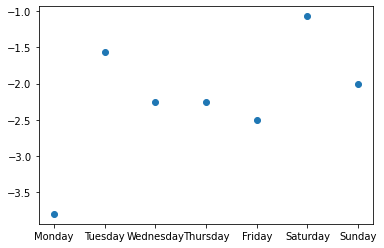

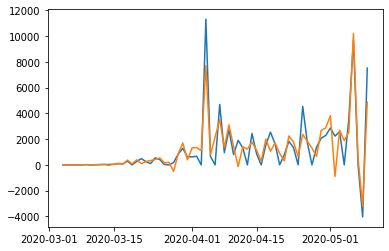

564


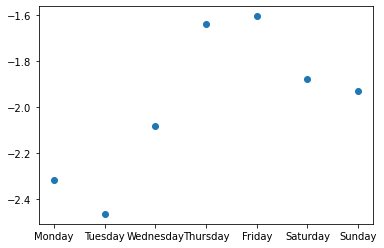

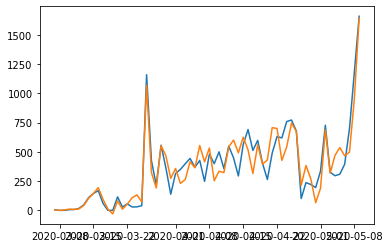

565


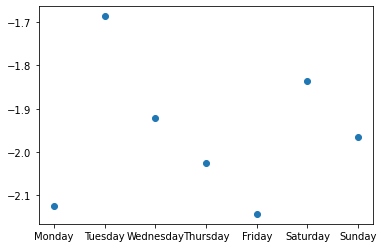

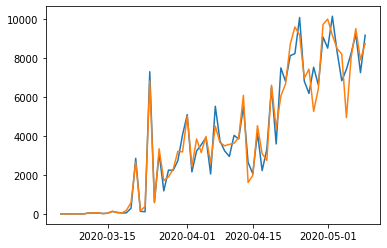

566


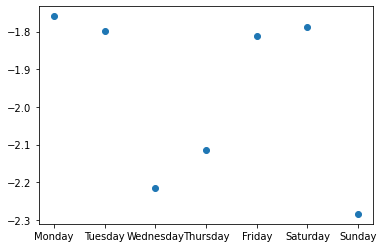

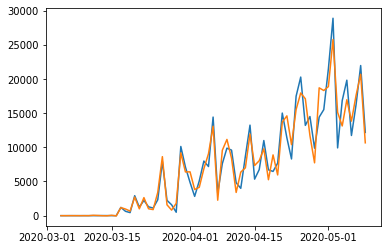

567


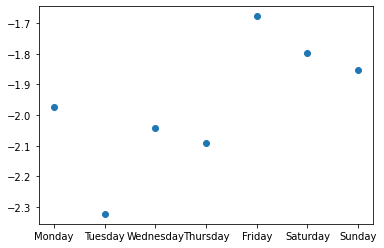

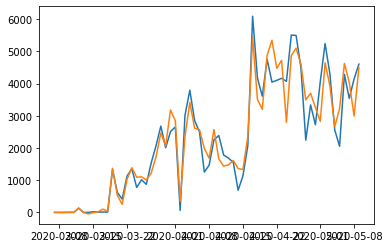

568


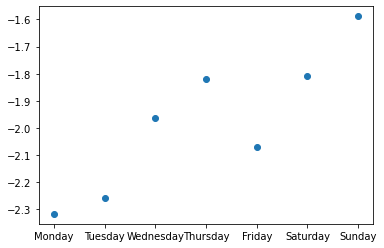

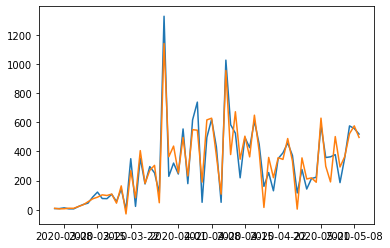

569


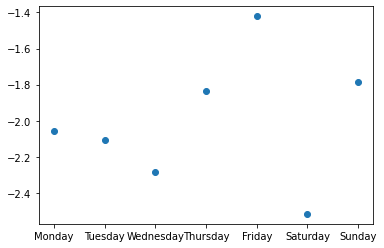

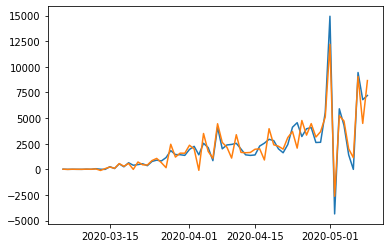

571


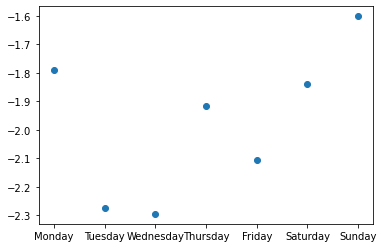

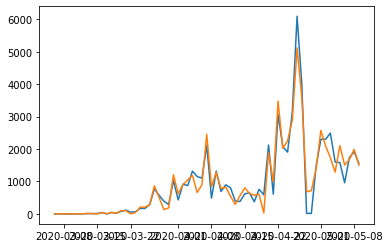

572


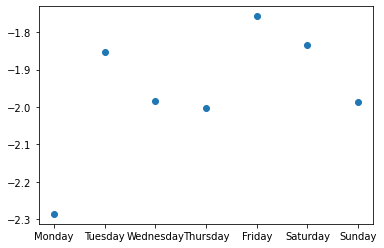

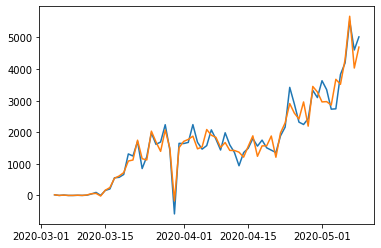

573


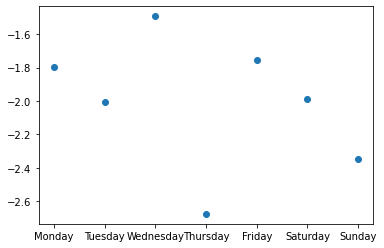

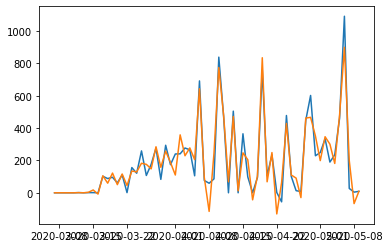

In [156]:
for location_id in test_df.location_id.unique():
    print(location_id)
    df = test_df.set_index(COLUMNS.location_id).loc[location_id]
    cum_count_var = 'Tests'

    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['Day of week'] = df[COLUMNS.date].apply(lambda x: weekdays[x.weekday()])
    df = pd.concat([df, pd.get_dummies(df['Day of week'])], axis=1)
    df['Week'] = np.floor(np.arange(len(df)) / 7)
    df['Week'] = df['Week'].astype(int)
    df['Days in week'] = df.groupby('Week')['Week'].transform('count')
    df['intercept'] = 1

    df['Daily'] = get_daily(df, cum_count_var)
    df['Weekly'] = df.groupby('Week')['Daily'].transform(sum)

    df = df.loc[~df[['Daily'] + weekdays].isnull().any(axis=1)]
    
    mod_df = df.loc[df['Days in week'] == 7]

    weekmod = sm.GLM(mod_df['Daily'], mod_df[weekdays], family=sm.families.Poisson(), offset=np.log(mod_df['Weekly'])).fit()
    weekmod.summary()
    plt.scatter(weekdays, weekmod.params)
    plt.show()

    df['pred'] = weekmod.predict(df[weekdays], offset=np.log(df['Weekly']))
    df['residual'] = df['Daily'] - df['pred']
    df['val'] = df['residual'] + np.exp(weekmod.params).mean() * df['Weekly']

    plt.plot(df['Date'], 
             df['Daily'])
    plt.plot(df['Date'], 
             df['val'])
    plt.show()

    # for w in range(1, df['Week'].max()+1):
    #     plt.plot(df.loc[df['Week'] == w, 'Date'], 
    #              df.loc[df['Week'] == w, 'Daily'])
    #     plt.plot(df.loc[df['Week'] == w, 'Date'], 
    #              df.loc[df['Week'] == w, 'val'])
    #     plt.title(f"Week {w} of {df['Week'].max()}")
    #     plt.show()


# load data

In [138]:
## location data
loc_df = get_us_locations()

## cases
case_df = pd.read_csv(f'/ihme/covid-19/model-inputs/{CASE_VERSION}/full_data.csv')
case_df[COLUMNS.date] = pd.to_datetime(case_df[COLUMNS.date])
case_df = case_df.loc[case_df[COLUMNS.location_id].isin(loc_df[COLUMNS.location_id].to_list())]
case_df[COLUMNS.location_id] = case_df[COLUMNS.location_id].astype(int)
case_df = case_df[[COLUMNS.location_id, COLUMNS.date, 'Confirmed', 'Confirmed case rate', 'population']].reset_index(drop=True)
case_df = case_df.sort_values(['location_id', COLUMNS.date]).reset_index(drop=True)

## raw test data
test_df = pd.read_csv('/ihme/covid-19/snapshot-data/best/covid_onedrive/Testing/us_states_tests.csv')
test_df[COLUMNS.date] = pd.to_datetime(test_df['date'], format='%d.%m.%Y')
test_df = test_df.loc[test_df[COLUMNS.location_id].isin(loc_df[COLUMNS.location_id].to_list())]
test_df[COLUMNS.location_id] = test_df[COLUMNS.location_id].astype(int)
test_df = test_df.rename(index=str, columns={'totaltestresults':'Tests'})
test_df = test_df[[COLUMNS.location_id, COLUMNS.date, 'Tests']].merge(case_df[['location_id', 'population']].drop_duplicates())
test_df = test_df.sort_values(['location_id', COLUMNS.date]).reset_index(drop=True)


# case_df['cum_cases'] = np.exp(case_df['ln(case rate)']) * case_df['population']
# case_df = case_df.sort_values(['location_id', 'date'])
# first_date = (case_df['date'] == case_df.groupby('location_id')['date'].transform(min)).values
# daily_cases = case_df['cum_cases'].values[1:] - case_df['cum_cases'].values[:-1]
# daily_cases = daily_cases[~first_date[1:]]
# case_df['cases'] = np.nan
# case_df.loc[~first_date, 'cases'] = daily_cases
# case_df = case_df[['location_id', 'location_name', 'date', 'cases', 'population']]

# ## infections (shifted forward 11 days)
# inf_df = pd.read_csv(f'/ihme/covid-19/seir-inputs/{INF_VERSION}/prepped_deaths_and_cases_all_age.csv')
# inf_df = inf_df.rename(index=str, columns={'loc_id':'location_id', 'cases_mean':'infections'})
# inf_df['date'] = pd.to_datetime(inf_df['date'])
# inf_df['date'] = inf_df['date'].apply(lambda x: x + pd.Timedelta(days=11))
# inf_df = inf_df[['location_id', 'date', 'infections']]

# ## testing
# test_df = pd.read_csv(f'/ihme/covid-19/testing-outputs/{TEST_VERSION}/data_smooth.csv')
# test_df = test_df.loc[~test_df['daily_total'].isnull()]
# test_df = test_df.rename(index=str, columns={'daily_total':'tests'})
# test_df['date'] = pd.to_datetime(test_df['date'])
# test_df = test_df.loc[test_df['daily_total_reported'] > 1000]
# test_df = test_df[['location_id', 'date', 'tests']]

# ## combine to model data
# df = reduce(lambda x, y: pd.merge(x, y), [case_df, inf_df, test_df])
# df = df[~df.isnull().any(axis=1)]
# df['intercept'] = 1
# df = df.sort_values(['location_id', 'date']).reset_index(drop=True)

# ## convert variables to rates
# df['case_rate'] = df['cases'] / df['population']
# df['infection_rate'] = df['infections'] / df['population']
# df['testing_rate'] = df['tests'] / df['population']
# df['case_detection'] = df['case_rate'] / df['infection_rate']

# ## get log
# df['ln_case_detection'] = np.log(df['case_detection'])
# df['ln_testing_rate'] = np.log(df['testing_rate'])

# ## subset to locations with > 100 deaths
# with open(f'/ihme/covid-19/deaths/prod/{CASE_VERSION}/checkpoint/full_data.pkl', 'rb') as fopen:
#     death_df = pickle.load(fopen)
# keep_locs = death_df.loc[death_df['Deaths'] > 200, 'location_id'].unique().tolist()
# df = df.loc[df['location_id'].isin(keep_locs)].reset_index(drop=True)

# ## subset to <1
# df = df.loc[df['case_detection'] < 1]

## run model

In [ ]:
mixed_mod = sm.MixedLM(endog=df['case_detection'].values, 
                       exog=df[['intercept', 'testing_rate']].values, 
                       groups=df['location_id'].values,
                       exog_re=df[['intercept', 'testing_rate']].values)
mixed_mod_fit = mixed_mod.fit()
mixed_mod_fit.summary()


In [ ]:
x = np.linspace(0, 0.003, 100)
pred = mixed_mod_fit.params[0] + mixed_mod_fit.params[1] * x
plt.scatter(df['testing_rate'].values,
            df['case_detection'].values)
plt.plot(x, pred, color='red')
plt.show()


In [ ]:
plt.figure(figsize=(11, 8.5))
plt.scatter(df['testing_rate'].values,
            df['case_detection'].values,
            c='dodgerblue', edgecolors='navy', alpha=0.5, s=100)
plt.plot(x, pred, color='maroon', linewidth=3, linestyle='--', alpha=0.75)
xlims = np.percentile(df['testing_rate'], (0, 100))
xlims = xlims + np.hstack([-np.diff(xlims)*0.1, np.diff(xlims)*0.1])
ylims = np.percentile(df['case_detection'], (0, 100)) * np.array([0.8, 1.2])
ylims = ylims + np.hstack([-np.diff(ylims)*0.1, np.diff(ylims)*0.1])
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Overall')
plt.show()

for location_id, re_params in mixed_mod_fit.random_effects.items():
    loc_pred = pred + re_params['x_re1'] + x * re_params['x_re2']
    plt.figure(figsize=(11, 8.5))
    plt.scatter(df['testing_rate'].values,
                df['case_detection'].values,
                c='none', edgecolors='navy', alpha=0.25, s=100)
    plt.scatter(df.loc[df['location_id'] == location_id, 'testing_rate'].values,
                df.loc[df['location_id'] == location_id, 'case_detection'].values,
                c='dodgerblue', edgecolors='navy', alpha=0.75, s=150)
    plt.plot(x, pred, color='maroon', linestyle='--', alpha=0.5)
    plt.plot(x, loc_pred, color='maroon', alpha=0.75)
    xlims = np.percentile(df.loc[df['location_id'] == location_id, 'testing_rate'], (0, 100))
    xlims = xlims + np.hstack([-np.diff(xlims)*0.1, np.diff(xlims)*0.1])
    ylims = np.percentile(df.loc[df['location_id'] == location_id, 'case_detection'], (0, 100)) * np.array([0.8, 1.2])
    ylims = ylims + np.hstack([-np.diff(ylims)*0.1, np.diff(ylims)*0.1])
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title(df.loc[df['location_id'] == location_id, 'location_name'].values[0])
    plt.show()
